In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.special import erfc
from scipy.integrate import quad

from glam_gen_data import ExampleModel


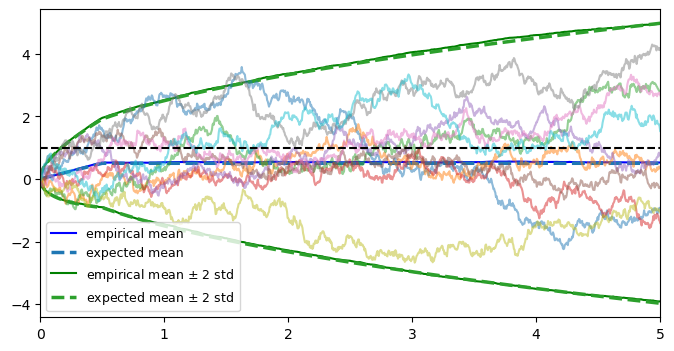

In [2]:
mu = 1.0
b = 1.0
T = 0.5
model = ExampleModel(mu=mu, b=b, T=T)


num = 3000
t_grid, X_grids = model.simulate_trajs(T=5, Nt=1000, num=num)

expected_mean = mu * np.minimum(t_grid, T)
empirical_mean = np.mean(X_grids, axis=0)
expected_std = np.sqrt(t_grid)
empirical_std = np.std(X_grids, axis=0)


fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t_grid, empirical_mean, label="empirical mean", c="b")
ax.plot(t_grid, expected_mean, label="expected mean", linewidth=2.5, linestyle="--", c="tab:blue")
ax.plot(t_grid, empirical_mean + 2 * empirical_std, label=r"empirical mean $\pm$ 2 std", c="g")
ax.plot(t_grid, empirical_mean - 2 * empirical_std, c="g")
ax.plot(t_grid, expected_mean + 2 * expected_std, label=r"expected mean $\pm$ 2 std", linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, expected_mean - 2 * expected_std, linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, X_grids[:10, :].T, alpha=0.5)
ax.plot(t_grid, model.upper_bdy(t_grid), c='k', linestyle="--")
ax.plot(t_grid, model.lower_bdy(t_grid), c='k', linestyle="--")
ax.autoscale(axis="x", tight=True)
ax.legend(fontsize=9)
plt.show()

In [4]:
!python3 glam_gen_data.py --mu 1 --b 1 --T 0.5 --dt 0.0001 --num 11000 --T_max 10000

Time step 0: 11000 paths active at t=0.000000.
Time step 10000: 4990 paths active at t=1.000000.
Time step 20000: 3557 paths active at t=2.000000.
Time step 30000: 2917 paths active at t=3.000000.
Time step 40000: 2492 paths active at t=4.000000.
Time step 50000: 2251 paths active at t=5.000000.
Time step 60000: 2044 paths active at t=6.000000.
Time step 70000: 1892 paths active at t=7.000000.
Time step 80000: 1768 paths active at t=8.000000.
Time step 90000: 1665 paths active at t=9.000000.
Time step 100000: 1569 paths active at t=10.000000.
Time step 110000: 1489 paths active at t=11.000000.
Time step 120000: 1424 paths active at t=12.000000.
Time step 130000: 1358 paths active at t=13.000000.
Time step 140000: 1313 paths active at t=14.000000.
Time step 150000: 1256 paths active at t=15.000000.
Time step 160000: 1204 paths active at t=16.000000.
Time step 170000: 1172 paths active at t=17.000000.
Time step 180000: 1140 paths active at t=18.000000.
Time step 190000: 1108 paths active

In [ ]:
fpt_data = pickle.load(open("glam_data_20251012-202520.pkl", "rb"))
num_data = min(10000, len(fpt_data["fp_times"]))
fp_times = fpt_data["fp_times"][:num_data]

In [6]:
len(fpt_data["fp_times"]), len(fp_times), fp_times.min(), fp_times.max()

(10952, 10000, 0.06245000000000076, 8581.963159227205)

In [7]:
def mu_tilde(b, mu, T):
    # Probability P(tau <= T)
    P_tau_leq_T = (1 - 0.5 * erfc((T * mu - b) / np.sqrt(2 * T)) 
                   + 0.5 * np.exp(2 * b * mu) * erfc((T * mu + b) / np.sqrt(2 * T)))
    
    # Expectation E[tau * 1{tau <= T}]
    E_tau_1_tau_leq_T = (b / mu) * (1 - 0.5 * erfc((T * mu - b) / np.sqrt(2 * T))
                                    - 0.5 * np.exp(2 * b * mu) * erfc((T * mu + b) / np.sqrt(2 * T)))
    
    # Expectation E[T/tau * 1{tau > T}]
    def integrand(t):
        prefactor = T / (2 * np.sqrt(2 * np.pi) * t ** (5 / 2))
        exp_term1 = np.exp(-((T * mu - b) ** 2) / (2 * t) + (2 * b * (t - T) * mu) / t)
        exp_term2 = np.exp(-((T * mu - b) ** 2) / (2 * t))
        
        erfc_term1 = (T * mu + b) * erfc((T * mu + b) * np.sqrt((t - T) / (2 * t * T)))
        erfc_term2 = (T * mu - b) * erfc((T * mu - b) * np.sqrt((t - T) / (2 * t * T)))
        
        return prefactor * (exp_term1 * erfc_term1 - exp_term2 * erfc_term2)
    
    E_T_over_tau_1_tau_gt_T, _ = quad(integrand, T, np.inf)
    
    # Compute mu_tilde
    numerator = P_tau_leq_T * b + E_T_over_tau_1_tau_gt_T * b
    denominator = E_tau_1_tau_leq_T + E_T_over_tau_1_tau_gt_T * T
    
    return numerator / denominator

In [8]:
def alpha_func(mu, t, T):
    t = np.asarray(t)
    mask = t < T
    result = np.where(mask, mu, (T / t) * mu)
    return result

$\mathcal{L}_{\mathrm{GLAM}}(\mu \mid \tau)=\frac{b}{\sqrt{2 \pi \tau^3}} e^{-\frac{(b-\alpha(\mu, \tau, \tau) \tau)^2}{2 \tau}}$

$\ell_n\left(\mu \mid \tau_1, \cdots, \tau_n\right)=-n \log (b)+\frac{n}{2} \log (2 \pi)+\sum_{i=1}^n\left(\frac{3}{2} \log \tau_i+\frac{1}{2 \tau_i}\left(b-\alpha\left(\mu, \tau_i, T\right) \tau_i\right)^2\right)$

In [9]:
def glam_likelihood(mu, b, T, fp_times):
    log_fpt = np.log(fp_times)
    alpha = alpha_func(mu, fp_times, T)
    return np.sum(1.5 * log_fpt + 0.5 / fp_times * (b - alpha * fp_times)**2)

def addm_likelihood(mu, b, T, fp_times):
    tau = np.asarray(fp_times)  # Ensure tau is treated as an array

    # Case 1: tau <= T
    mask1 = tau <= T
    term1 = (b / np.sqrt(2 * np.pi * tau**3)) * np.exp(-((b - mu * tau)**2) / (2 * tau))
    
    # Case 2: tau > T
    mask2 = ~mask1  # Complement of mask1
    sqrt_factor = np.sqrt((tau - T) / (2 * T * tau))
    erfc1 = erfc((T * mu + b) * sqrt_factor)
    erfc2 = erfc((T * mu - b) * sqrt_factor)
    
    term2_prefactor = 1 / (2 * np.sqrt(2 * np.pi * tau**3))
    exp_factor = np.exp((2 * b * mu * (tau - T)) / tau)
    term2 = term2_prefactor * np.exp(-((T * mu - b)**2) / (2 * tau)) * (
        exp_factor * (T * mu + b) * erfc1 - (T * mu - b) * erfc2
    )
    
    # Combine both cases
    likelihood = np.where(mask1, term1, term2)
    result = -np.sum(np.log(likelihood))
    
    return result

    

In [10]:


# Perform scalar minimization
result = minimize_scalar(glam_likelihood, args=(b, T, fp_times))

# Extract the optimal mu
mu_glam = result.x

# Print the result
print("Optimized mu_glam:", mu_glam)
print("mu_tilde:", mu_tilde(fpt_data["b"], fpt_data["mu"], fpt_data["T"]))
print("b / T: ", fpt_data["b"] / fpt_data["T"])


Optimized mu_glam: 2.606266502987696
mu_tilde: 2.612834945851152
b / T:  2.0


In [11]:
# Perform scalar minimization
result = minimize_scalar(addm_likelihood, args=(b, T, fp_times))

# Extract the optimal mu
mu_ML = result.x

# Print the result
print("Optimized mu_ML:", mu_ML)
print("mu:", fpt_data["mu"]) 

Optimized mu_ML: 0.9961120523525457
mu: 1.0


/tmp/ipykernel_2594140/1929659231.py:15: RuntimeWarning: invalid value encountered in sqrt
  sqrt_factor = np.sqrt((tau - T) / (2 * T * tau))
